In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [2]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [3]:
X.shape

torch.Size([100, 4])

In [4]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.error = ((y_pred - y_true) ** 2).mean()
        return self.error
    
    def backward(self):
#         return 2 * (y_pred - y_true)
        return self.error.backward()
         

In [5]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad = True)
        self.bias = torch.randn(1, requires_grad = True)
        
    def forward(self, inputs):
        self.inputs = inputs
        return torch.matmul(inputs, self.weights) + self.bias

    def backward(self):        
        # dvalue - значение градиента, которое приходит нейрону от следующего слоя сети
        # в данном случае это будет градиент L по y^ (созданный методом backwards у объекта MSELoss)
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db


In [6]:
n_inputs = 4 # X.shape
learning_rate = 0.001 #  скорость обучения
n_epoch = 100 #  количество эпох
    
neuron = Neuron(n_inputs)
loss = SquaredLoss()

losses = []
for epoch in range(100):
    if epoch % 10 == 0: 
        pass
#         print(f"Эпоха {epoch}")
#         print(f"neuron.weights {neuron.weights}")
#         print(f"neuron.bias {neuron.bias}")

    for x_example, y_example in zip(X, y):
        # forward pass
        y_pred = neuron.forward(x_example)
        curr_loss = loss.forward(y_pred, y_example)
        losses.append(curr_loss.detach().numpy())

        # backprop
        
        loss.backward()
        # <вызов методов backward>
        # обратите внимание на последовательность вызовов: от конца к началу
        neuron.backward()
        with torch.no_grad():
            neuron.weights -= learning_rate * neuron.dweights
            neuron.bias -= learning_rate * neuron.dbias
        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()
        # <шаг оптимизации для весов (weights и bias) нейрона>
        
print(neuron.weights)


tensor([ 8.7362,  8.2291, 11.6165, 91.9918], requires_grad=True)


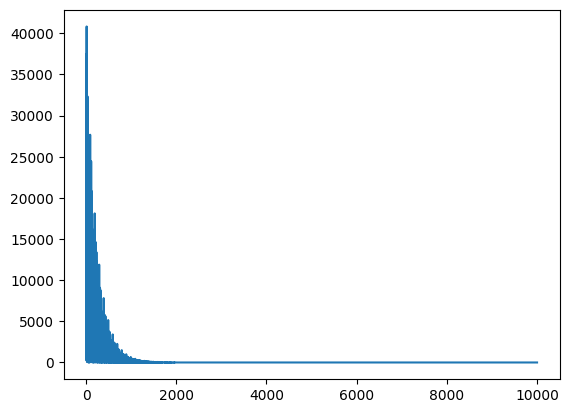

In [7]:
index = np.arange(1, len(losses) + 1)
plt.plot(index, np.array(losses))

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [8]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [9]:
X.shape , y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [10]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs.clip(min=0)
        return self.output

In [11]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.error =((y_true - y_pred)**2).mean()
        return self.error

In [12]:
class Linear:
    def __init__(self, n_features, n_neurons):
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.biases = torch.randn(n_neurons, requires_grad=True)
  
    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.biases

In [13]:
n_inputs = 1
n_neurons = 50
learning_rate = 0.01
num_epochs = 10000

fc1 = Linear(n_inputs, n_neurons)
relu = Activation_ReLU()
fc2 = Linear(n_neurons, 1)
loss = MSELoss()

losses = []
for epoch in range(num_epochs):
    hidden = relu.forward(fc1.forward(X))
    output = fc2.forward(hidden)

    data_loss = loss.forward(output, y)
    losses.append(data_loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch} Mean Loss: {data_loss.item()}')
        

    data_loss.backward()

    with torch.no_grad():
        fc1.weights -= learning_rate * fc1.weights.grad
        fc1.biases -= learning_rate * fc1.biases.grad
        fc2.weights -= learning_rate * fc2.weights.grad
        fc2.biases -= learning_rate * fc2.biases.grad
    
    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()
    

        
        


Epoch 0 Mean Loss: 39.120052337646484
Epoch 1000 Mean Loss: 0.10222823917865753
Epoch 2000 Mean Loss: 0.07943253219127655
Epoch 3000 Mean Loss: 0.057803619652986526
Epoch 4000 Mean Loss: 0.039467573165893555
Epoch 5000 Mean Loss: 0.02580566704273224
Epoch 6000 Mean Loss: 0.016750367358326912
Epoch 7000 Mean Loss: 0.011243837885558605
Epoch 8000 Mean Loss: 0.00802994892001152
Epoch 9000 Mean Loss: 0.0061971223913133144


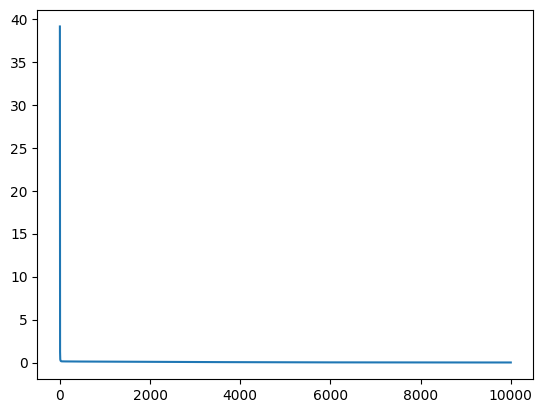

In [14]:
index = np.arange(1, len(losses) + 1)
plt.plot(index, np.array(losses))

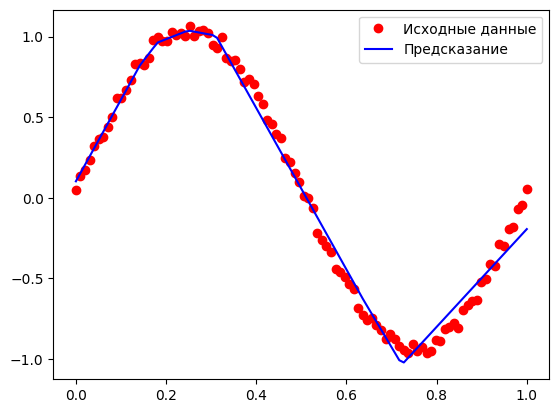

In [15]:
with torch.no_grad():
    test_hidden = relu.forward(fc1.forward(X))
    test_output = fc2.forward(test_hidden)

plt.plot(X, y, 'ro', label='Исходные данные')
plt.plot(X, test_output, 'b', label='Предсказание')
plt.legend()
plt.show()

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [16]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [17]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [18]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.error = ((y_pred - y_true) ** 2).mean()
        return self.error
    
    def backward(self):
#         return 2 * (y_pred - y_true)
        return self.error.backward()
         

In [19]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad = True)
        self.bias = torch.randn(1, requires_grad = True)
        
    def forward(self, inputs):
        self.inputs = inputs
        return torch.matmul(inputs, self.weights) + self.bias

    def backward(self):        
        # dvalue - значение градиента, которое приходит нейрону от следующего слоя сети
        # в данном случае это будет градиент L по y^ (созданный методом backwards у объекта MSELoss)
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db


In [20]:
n_inputs = 4 
learning_rate = 0.001 
n_epoch = 100 

neuron = Neuron(n_inputs)
loss = SquaredLoss()

losses = []



optimizer = optim.SGD([neuron.weights, neuron.bias], lr=learning_rate)


for epoch in range(100):
    if epoch % 10 == 0: 
        pass
        print(f"Эпоха {epoch}")
        print(f"neuron.weights {neuron.weights}")
        print(f"neuron.bias {neuron.bias}")

    for x_example, y_example in zip(X, y):
        
        y_pred = neuron.forward(x_example)
        curr_loss = loss.forward(y_pred, y_example)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(curr_loss.item())



        
print(neuron.weights)


Эпоха 0
neuron.weights tensor([-0.5556, -1.0470, -0.4143, -1.0779], requires_grad=True)
neuron.bias tensor([0.4388], requires_grad=True)
Эпоха 10
neuron.weights tensor([75.9523, 43.1895, 64.0851, 59.4510], requires_grad=True)
neuron.bias tensor([-4.8683], requires_grad=True)
Эпоха 20
neuron.weights tensor([88.7991, 44.9640, 71.7877, 66.7131], requires_grad=True)
neuron.bias tensor([-1.0888], requires_grad=True)
Эпоха 30
neuron.weights tensor([91.0035, 44.8407, 72.8572, 67.8477], requires_grad=True)
neuron.bias tensor([0.1304], requires_grad=True)
Эпоха 40
neuron.weights tensor([91.3946, 44.7885, 73.0177, 68.0572], requires_grad=True)
neuron.bias tensor([0.4205], requires_grad=True)
Эпоха 50
neuron.weights tensor([91.4663, 44.7777, 73.0423, 68.0987], requires_grad=True)
neuron.bias tensor([0.4834], requires_grad=True)
Эпоха 60
neuron.weights tensor([91.4797, 44.7758, 73.0461, 68.1071], requires_grad=True)
neuron.bias tensor([0.4966], requires_grad=True)
Эпоха 70
neuron.weights tensor([9

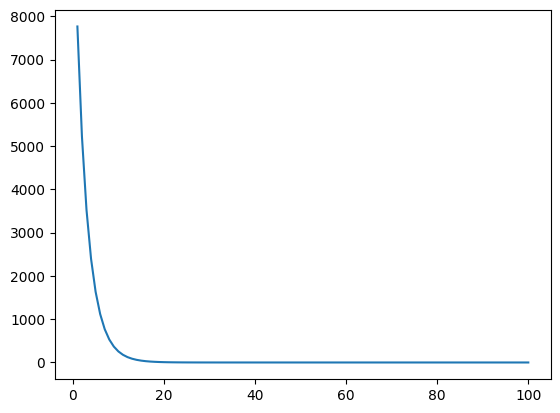

In [21]:
index = np.arange(1, len(losses) + 1)
plt.plot(index, np.array(losses))

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [23]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [24]:
X.shape , y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [25]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs.clip(min=0)
        return self.output

In [26]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.error =((y_true - y_pred)**2).mean()
        return self.error

In [27]:
class Linear:
    def __init__(self, n_features, n_neurons):
        self.weights = torch.randn(n_features, n_neurons, requires_grad = True)
        self.biases = torch.randn(n_neurons, requires_grad = True)
  
    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.biases

In [29]:
n_inputs = 1
n_neurons = 50
learning_rate = 0.001
num_epochs = 10000

fc1 = Linear(n_inputs, n_neurons)
relu = Activation_ReLU()
fc2 = Linear(n_neurons, 1)
loss = MSELoss()
batch_size = 25

optimizer = optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr=learning_rate)

losses = []

for epoch in range(10000):
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} Mean Loss: {data_loss}')

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        

        hidden = fc1.forward(batch_X)
        relu_output = relu.forward(hidden)
        output = fc2.forward(relu_output)

        data_loss = loss.forward(output, batch_y)
        optimizer.zero_grad()

        data_loss.backward()


        optimizer.step()
    losses.append(data_loss.item())


Epoch 0 Mean Loss: 0.0008168589556589723
Epoch 1000 Mean Loss: 0.043285876512527466
Epoch 2000 Mean Loss: 0.002023428911343217
Epoch 3000 Mean Loss: 0.000987187959253788
Epoch 4000 Mean Loss: 0.0009982775663957
Epoch 5000 Mean Loss: 0.0009984858334064484
Epoch 6000 Mean Loss: 0.0009938643779605627
Epoch 7000 Mean Loss: 0.0009904117323458195
Epoch 8000 Mean Loss: 0.0008980435086414218
Epoch 9000 Mean Loss: 0.0008824387914501131


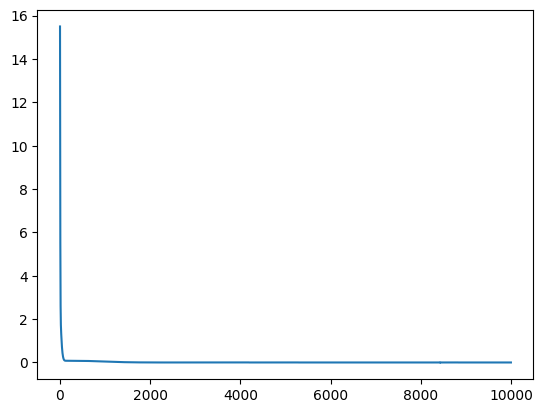

In [30]:
index = np.arange(1, len(losses) + 1)
plt.plot(index, np.array(losses))

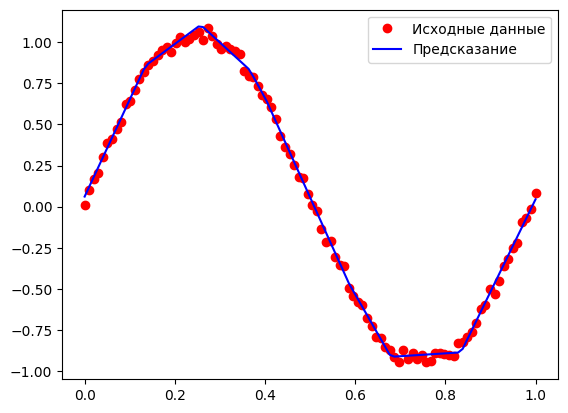

In [31]:
with torch.no_grad():
    test_hidden = relu.forward(fc1.forward(X))
    test_output = fc2.forward(test_hidden)

plt.plot(X, y, 'ro', label='Исходные данные')
plt.plot(X, test_output, 'b', label='Предсказание')
plt.legend()
plt.show()

## 3.3 Построение сетей при помощи `torch.nn`

In [32]:
import torch.nn as nn

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [33]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

Эпоха [1000/10000], Потеря: 0.0749630481004715
Эпоха [2000/10000], Потеря: 0.050868626683950424
Эпоха [3000/10000], Потеря: 0.04328912869095802
Эпоха [4000/10000], Потеря: 0.037796150892972946
Эпоха [5000/10000], Потеря: 0.0341586135327816
Эпоха [6000/10000], Потеря: 0.029791660606861115
Эпоха [7000/10000], Потеря: 0.028595736250281334
Эпоха [8000/10000], Потеря: 0.025714609771966934
Эпоха [9000/10000], Потеря: 0.02435731142759323
Эпоха [10000/10000], Потеря: 0.019864153116941452


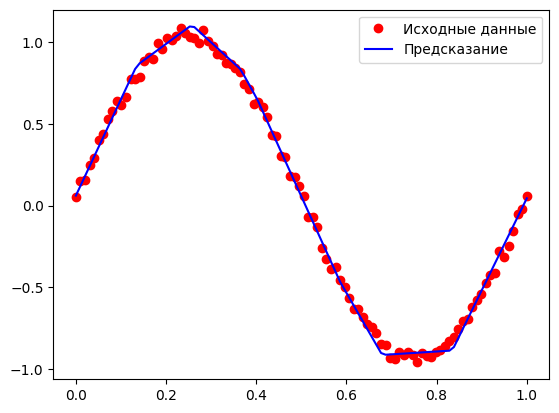

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

class Regression(nn.Module):
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(1, 50)  
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(50, 1)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model = Regression()

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 10000

for epoch in range(num_epochs):
    outputs = model(X)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потеря: {loss.item()}')



model.eval()
with torch.no_grad():
    predicted = model(X)
    
plt.plot(X, y, 'ro', label='Исходные данные')
plt.plot(X, test_output, 'b', label='Предсказание')
plt.legend()
plt.show()


3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

Эпоха [1000/10000], Потеря: 0.13870027661323547
Эпоха [2000/10000], Потеря: 0.11199790984392166
Эпоха [3000/10000], Потеря: 0.08693847060203552
Эпоха [4000/10000], Потеря: 0.06493762135505676
Эпоха [5000/10000], Потеря: 0.046643730252981186
Эпоха [6000/10000], Потеря: 0.032556090503931046
Эпоха [7000/10000], Потеря: 0.022588161751627922
Эпоха [8000/10000], Потеря: 0.01605072058737278
Эпоха [9000/10000], Потеря: 0.011984162032604218
Эпоха [10000/10000], Потеря: 0.009432987309992313


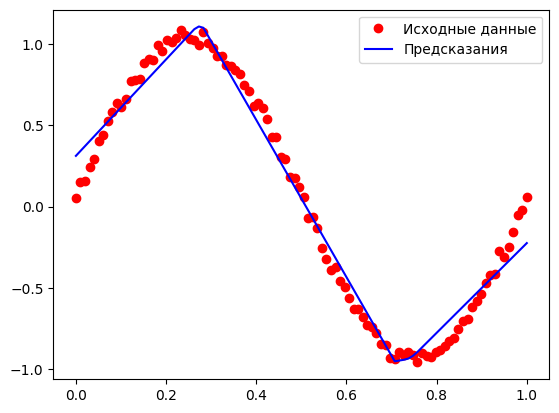

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Гиперпараметры
n_inputs = 1
n_neurons = 50
learning_rate = 0.01
num_epochs = 10000

model = nn.Sequential(
    nn.Linear(n_inputs, n_neurons),  
    nn.ReLU(),  
    nn.Linear(n_neurons, 1)  
)

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    outputs = model(X)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потеря: {loss.item()}')



model.eval()
with torch.no_grad():
    predicted = model(X)
    
plt.plot(X, y,'ro', label='Исходные данные')
plt.plot(X, predicted, 'b', label='Предсказания')
plt.legend()
plt.show()


## 3.4. Datasets and dataloaders

In [43]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [45]:
class SinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Эпоха [1000/10000], Потеря: 0.001092349411919713
Эпоха [2000/10000], Потеря: 0.0005526316817849874
Эпоха [3000/10000], Потеря: 0.0012614029692485929
Эпоха [4000/10000], Потеря: 0.0011443238472566009
Эпоха [5000/10000], Потеря: 0.0010536543559283018
Эпоха [6000/10000], Потеря: 0.00039533217204734683
Эпоха [7000/10000], Потеря: 0.0007976437918841839
Эпоха [8000/10000], Потеря: 0.001699279062449932
Эпоха [9000/10000], Потеря: 0.0005985828465782106
Эпоха [10000/10000], Потеря: 0.001209154142998159


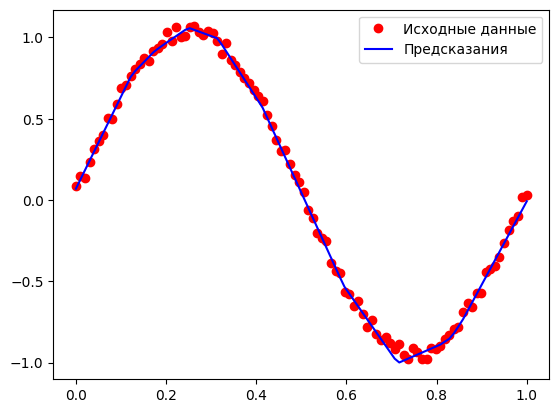

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Создание данных
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

# Гиперпараметры
n_inputs = 1
n_neurons = 50
learning_rate = 0.01
num_epochs = 10000
batch_size = 10


dataset = SinDataset(X, y)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потеря: {loss.item()}')

model.eval()
with torch.no_grad():
    predicted = model(X)
    
plt.plot(X, y,'ro', label='Исходные данные')
plt.plot(X, predicted, 'b', label='Предсказания')
plt.legend()
plt.show()


3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

In [94]:
class DiamondsDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [95]:
data = pd.read_csv("diamonds.csv")
data

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [88]:

data = data.drop(['Unnamed: 0', 'cut', 'color', 'clarity'], axis=1)
target = torch.tensor(data["price"].values, dtype=torch.float32)
data = data.drop(columns=["price"])
data


,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...
53935,0.72,60.8,57.0,5.75,5.76,3.50
53936,0.72,63.1,55.0,5.69,5.75,3.61
53937,0.70,62.8,60.0,5.66,5.68,3.56
53938,0.86,61.0,58.0,6.15,6.12,3.74


In [89]:
data = torch.tensor(data.values, dtype=torch.float32)
dataset = DiamondsDataset(data, target)

In [90]:
tensor_data, target

(tensor([[ 0.2300, 61.5000, 55.0000,  3.9500,  3.9800,  2.4300],
         [ 0.2100, 59.8000, 61.0000,  3.8900,  3.8400,  2.3100],
         [ 0.2300, 56.9000, 65.0000,  4.0500,  4.0700,  2.3100],
         ...,
         [ 0.7000, 62.8000, 60.0000,  5.6600,  5.6800,  3.5600],
         [ 0.8600, 61.0000, 58.0000,  6.1500,  6.1200,  3.7400],
         [ 0.7500, 62.2000, 55.0000,  5.8300,  5.8700,  3.6400]]),
 tensor([ 326.,  326.,  327.,  ..., 2757., 2757., 2757.]))

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

In [91]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

In [108]:
model = nn.Sequential(
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

batch_size = 256
num_epochs = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) 

print(train_loader)
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_data, batch_target in train_loader:
        outputs = model(batch_data.float())
        loss = criterion(outputs, batch_target.view(-1, 1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Mean Loss: {avg_loss}')

Epoch [1/100], Mean Loss: 18331753.53846154
Epoch [11/100], Mean Loss: 2176733.347633136
Epoch [21/100], Mean Loss: 2163162.8439349113
Epoch [31/100], Mean Loss: 2154891.521449704
Epoch [41/100], Mean Loss: 2151080.7337278104
Epoch [51/100], Mean Loss: 2148721.8106508874
Epoch [61/100], Mean Loss: 2145969.0118343197
Epoch [71/100], Mean Loss: 2143001.3143491126
Epoch [81/100], Mean Loss: 2133331.1642011832
Epoch [91/100], Mean Loss: 2132352.977071006


3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 

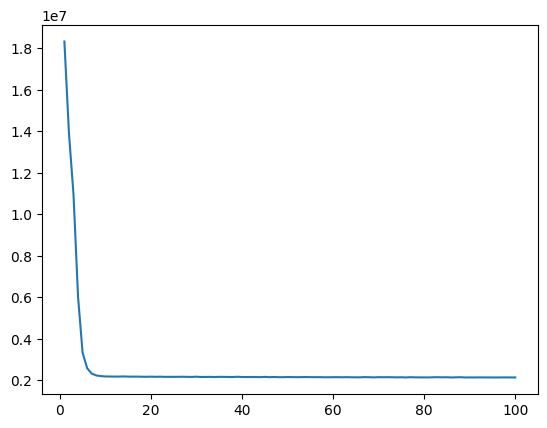

In [109]:
index = np.arange(1, len(losses) + 1)
plt.plot(index, np.array(losses))

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [181]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [200]:
class DropColsTransform:
    def __call__(self, sample):
        sample = sample.select_dtypes(include=[int, float])
        return sample

In [201]:
class ToTensorTransform:
    def __call__(self, sample):
        sample = torch.tensor(sample.values, dtype=torch.float32)
        return sample


In [218]:
from torchvision import transforms

data = pd.read_csv('diamonds.csv', index_col=0)

drop_transform = DropColsTransform()
to_tensor_transform = ToTensorTransform()

transform = transforms.Compose([drop_transform, to_tensor_transform])

dataset = DiamondsDataset(data, transform)

In [219]:
dataset